# Levelized Costs of Hydrogen
The LCoE is often used to compare different energy–generating technologies [70], [86], [111], [122]. This approach is applied by this master thesis to compute the LCoH2 issued by the PtH2 unit. The LCoH2 are calculated by equation 2.11 which includes the annual Capital Expenditures (CapEx), the annual Operating Expenditures (OpEx) and the annual amount of hydrogen produced mH2,a. The CapEx are considered according to the annuity method based on the norm DIN 2067 issued by the “Verein Deutsche Ingenieure” [142].

$LCoH_2 = \frac{CapEx_a + OpEx_a}{m_{H_2,a}}$
\begin{align*}
CapEx_a & : \text{Annual Capital Expenditures} \\
OpEx_a & : \text{Annual Operating Expenditures} \\
m_{H_2,a} & : \text{Annual mass of produced hydrogen}
\end{align*}


In [1]:
import pandas as pd
#data input
electrolyzers_df = pd.read_csv('/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/input/2016/electrolyzers.csv')
economic_assumption = pd.read_csv('/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/Data/economic_assumptions.csv')
display(electrolyzers_df)
display(economic_assumption)


,name,technology,minLoad,maxLoad,installedCapacity,effElec,minDowntime,coldStartUpCost,maxAllowedColdStartups,standbyCons,comprCons,maxSOC,company
0,Iron_steel,PEM,0.05,1.2,11850,0.63,0.5,50,3000,0.0005,0.0012,200000,Iron_steel


,technology,CAPEX,stack_replacement,maintanence_cost,discount_rate,lifetime,stack_lifetime,scaling_factor
0,PEM,1078,25.0,3,7,20,10.0,-0.1976
1,AEL,902,25.0,3,7,20,10.0,-0.1976
2,Storage,530,NaN,2,7,30,NaN,NaN
3,Compressor,2500,NaN,5,7,15,NaN,NaN


### CAPEX+OPEX Calculation
Calculating Electrolyzer CAPEX/OPEX
Stack replacement cost is assumed to happen once in project liftime.

In [2]:
elec_capacity = electrolyzers_df['installedCapacity'] #installed capacity of electrolyzer per subsector [MW]
elec_investment = economic_assumption['CAPEX']*1000 #Specifiv investment per MW installed [Euro/MW]
scaling_factor = -0.1976 #Scaling factor means the larger capacity, the cheaper it costs per electrolyzer MW installation [unitless]
elec_OPEX = economic_assumption['maintanence_cost'][0] #percentage of CAPEX [%] 
def calculate_elec_CAPEX(technology, capacity):
    if technology == 'PEM':
        CAPEX = (capacity * elec_investment[0])**scaling_factor + (capacity * elec_investment[0]*0.25)
    if technology == 'AEL':
        CAPEX = (capacity * elec_investment[1])**scaling_factor + (capacity * elec_investment[1]*0.25)
    return CAPEX

elec_CAPEX_iron_steel = calculate_elec_CAPEX(technology='PEM', capacity = elec_capacity[0])
elec_OPEX_iron_steel = elec_CAPEX_iron_steel*elec_OPEX/100
print('Iron and steel industry electrolyzer CAPEX:', round(elec_CAPEX_iron_steel/10e5, 3), 'Mln. Euro')
print('Iron and steel industry electrolyzer OPEX:', round(elec_OPEX_iron_steel/10e5, 3), 'Mln. Euro')


Iron and steel industry electrolyzer CAPEX: 3.194 Mln. Euro
Iron and steel industry electrolyzer OPEX: 0.096 Mln. Euro


Calculating Storage CAPEX/OPEX

In [4]:
storage_investment = economic_assumption['CAPEX'][2]*1000 #Specifiv investment per MW installed [Euro/MW]
storage_opex = economic_assumption['maintanence_cost'][2]
storage_cpacity = electrolyzers_df['maxSOC'] #installed storage capacity  [KG]

storage_CAPEX_iron_steel = storage_investment*storage_cpacity[0]
storage_OPEX_iron_steel = storage_CAPEX_iron_steel * storage_opex/100 

print('Iron and steel industry storage CAPEX:', round(storage_CAPEX_iron_steel/10e5, 3), 'Mln. Euro')
print('Iron and steel industry storage OPEX:', round(storage_OPEX_iron_steel/10e5, 3), 'Mln. Euro')

Iron and steel industry storage CAPEX: 106.0 Mln. Euro
Iron and steel industry storage OPEX: 2.12 Mln. Euro


Calculating Compressor CAPEX/OPEX
Compressor does not have fixed installed capacity, rather it is calculated based on the maximal hourly mass flow of H2 in different scenarios. 

In [14]:
#Compressor calculation for iron and steel industry (#repeat it for other subsectors)
iron_steel_schedule = pd.read_csv('/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/output/2016_w_opt/Elec_capacities/Iron_steel_optimizedBidAmount.csv')
display(iron_steel_schedule.columns)
compressor_investment = economic_assumption['CAPEX'][3] #Specifiv investment [Euro/kg/hour]
compressor_opex = economic_assumption['maintanence_cost'][3] #% of CAPEX
h2_mass_flow = iron_steel_schedule['electrolyzer_to_storage_h2'] #15min mass flow of hydrogen
hourly_h2_mass_flow = h2_mass_flow.groupby(h2_mass_flow.index // 4).sum() #resample 15min data into hours
compressor_capacity = max(hourly_h2_mass_flow)

compressor_CAPEX_iron_steel = storage_investment*compressor_capacity
compressor_OPEX_iron_steel = compressor_CAPEX_iron_steel*compressor_opex/100

print('Iron and steel industry compressor CAPEX:', round(compressor_CAPEX_iron_steel/10e5, 3), 'Mln. Euro')
print('Iron and steel industry compressor OPEX:', round(compressor_OPEX_iron_steel/10e5, 3), 'Mln. Euro')

Index(['Unnamed: 0', 'timestamp', 'bidQuantity', 'electrolyzer_consumption',
       'compressor_consumption', 'produced_h2', 'electrolyzer_to_plant_h2',
       'electrolyzer_to_storage_h2', 'storage_to_plant_h2', 'SOC', 'isRunning',
       'isStandBy', 'isIdle', 'isColdStarted', 'PFC', 'h2demand'],
      dtype='object')

Iron and steel industry compressor CAPEX: 40.46 Mln. Euro
Iron and steel industry compressor OPEX: 2.023 Mln. Euro


Calculate tolal CAPEX and OPEX

In [11]:
total_CAPEX_iron_steel = elec_CAPEX_iron_steel + storage_CAPEX_iron_steel + compressor_CAPEX_iron_steel
total_OPEX_iron_steel = elec_OPEX_iron_steel + storage_OPEX_iron_steel + compressor_OPEX_iron_steel

print('Iron and steel industry total CAPEX:', round(total_CAPEX_iron_steel/10e5, 3), 'Mln. Euro')
print('Iron and steel industry total OPEX:', round(total_OPEX_iron_steel/10e5, 3), 'Mln. Euro')


Iron and steel industry total CAPEX: 149.668 Mln. Euro
Iron and steel industry total OPEX: 4.24 Mln. Euro


### Electricity Cost Calculation

In [15]:
EOM_prices = pd.read_csv('/Users/kanankhasmammadov/Desktop/Thesis - Electrolyzer market participation/flexABLE_w_electrolyzer/output/2016_w_opt/EOM_Prices_W_opt.csv')
elec_price = EOM_prices['Price'] #EOM energy price [Euro/MWh]
purchased_energy_iron_steel = iron_steel_schedule['bidQuantity']*0.25 #energy purchase from market [MWh]
energy_cost_iron_steel = sum(purchased_energy_iron_steel*elec_price)
print('Iron and steel industry electricity cost:', round(energy_cost_iron_steel/10e5, 2), 'Mln. Euro')

Iron and steel industry electricity cost: 219.28 Mln. Euro


### LCOH calculation

In [69]:
# annuity_factor = 
energyContentH2_LHV = 0.03333
produced_H2_iron_steel_kg = sum(iron_steel_schedule['produced_h2']) #kg of total produced H2
produced_H2_iron_steel_Mwh = produced_H2_iron_steel_kg*
LCOH_iron_steel = (total_CAPEX_iron_steel+ total_OPEX_iron_steel+energy_cost_iron_steel)/produced_H2_iron_steel_kg
print('LCOH for Iron and steel industry :', round(LCOH_iron_steel, 2), 'Euro')

LCOH for Iron and steel industry : 3.87 Euro


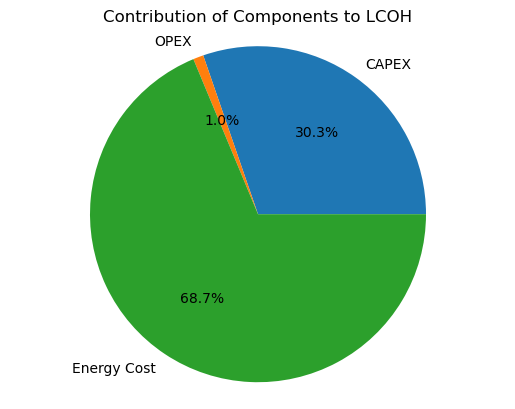

In [70]:
import matplotlib.pyplot as plt

# Calculate the percentage contribution of each component
components = ['CAPEX', 'OPEX', 'Energy Cost']
values = [total_CAPEX_iron_steel, total_OPEX_iron_steel, energy_cost_iron_steel]
total = sum(values)
percentages = [(value / total) * 100 for value in values]

# Create the pie chart
plt.pie(percentages, labels=components, autopct='%1.1f%%')
plt.title('Contribution of Components to LCOH')
plt.axis('equal')
plt.show()
